In [1]:
import tensorflow as tf

import numpy as np
import os
import matplotlib.pyplot as plt



2023-12-19 19:13:08.135481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 19:13:08.135514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 19:13:08.136454: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 19:13:08.142490: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 19:13:08.921881: W tensorflow/compiler/tf2

In [2]:
_URL_ = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL_, extract=True)


PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMAGE_SIZE)

Found 2000 files belonging to 2 classes.


2023-12-19 19:13:13.560076: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-19 19:13:13.587461: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-19 19:13:13.587712: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                shuffle=True,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMAGE_SIZE)

Found 1000 files belonging to 2 classes.


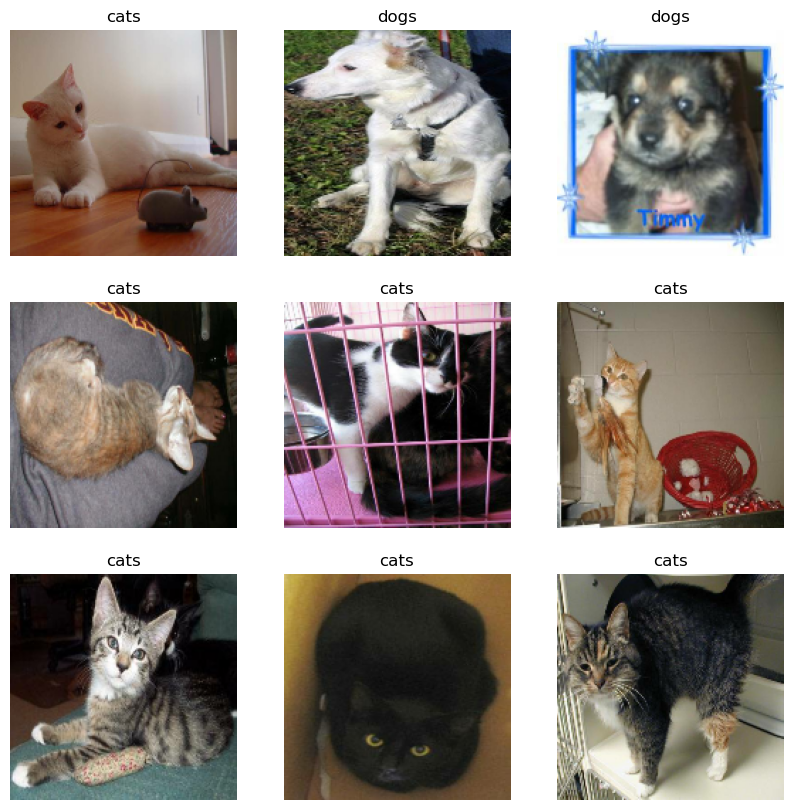

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 26
Number of test batches: 6


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

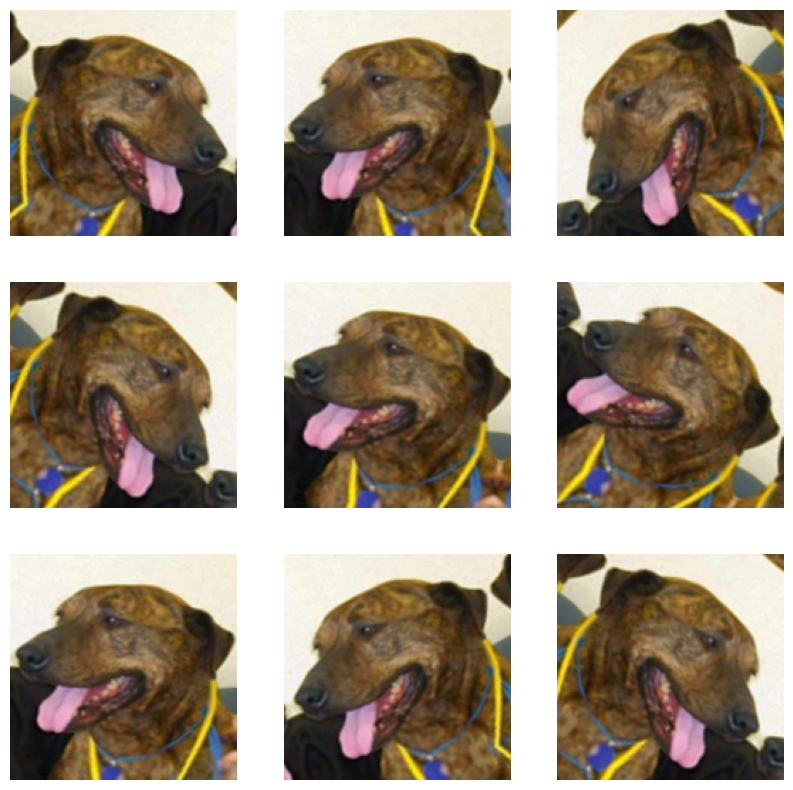

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [13]:
IMG_SHAPE = IMAGE_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-12-19 19:31:27.621519: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2023-12-19 19:31:27.690696: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(32, 5, 5, 1280)


In [15]:
base_model.trainable = False

In [16]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 40, 40, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 41, 41, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 20, 20, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 20, 20, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 10, 10, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 10, 10, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 10, 10, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 10, 10, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 10, 10, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 10, 10, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 10, 10, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 11, 11, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 5, 5, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 5, 5, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [18]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [19]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [22]:
len(model.trainable_variables)

2

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy'))

In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 5s 88ms/step - loss: 0.8698 - accuracy: 0.4666


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 0.87
initial accuracy: 0.47


In [27]:
history = model.fit(test_dataset, epochs=10, validation_data=validation_dataset, verbose=1)

Epoch 1/10
1/6 [====>.........................] - ETA: 22s - loss: 0.8223 - accuracy: 0.5000

2023-12-19 19:59:46.299989: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f938c86ece0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 19:59:46.300013: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-12-19 19:59:46.304400: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703026786.378907   25535 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 [==============================] - 6s 278ms/step - loss: 0.8107 - accuracy: 0.5312 - val_loss: 0.8436 - val_accuracy: 0.4740
Epoch 2/10
6/6 [==============================] - 2s 285ms/step - loss: 0.8643 - accuracy: 0.4635 - val_loss: 0.7864 - val_accuracy: 0.5111
Epoch 3/10
6/6 [==============================] - 2s 286ms/step - loss: 0.8177 - accuracy: 0.5365 - val_loss: 0.7599 - val_accuracy: 0.5173
Epoch 4/10
6/6 [==============================] - 1s 270ms/step - loss: 0.7911 - accuracy: 0.5469 - val_loss: 0.7230 - val_accuracy: 0.5619
Epoch 5/10
6/6 [==============================] - 2s 282ms/step - loss: 0.7697 - accuracy: 0.5208 - val_loss: 0.7010 - val_accuracy: 0.5866
Epoch 6/10
6/6 [==============================] - 1s 269ms/step - loss: 0.6900 - accuracy: 0.6250 - val_loss: 0.6655 - val_accuracy: 0.6126
Epoch 7/10
6/6 [==============================] - 2s 285ms/step - loss: 0.7182 - accuracy: 0.5729 - val_loss: 0.6407 - val_accuracy: 0.6460
Epoch 8/10
6/6 [===============

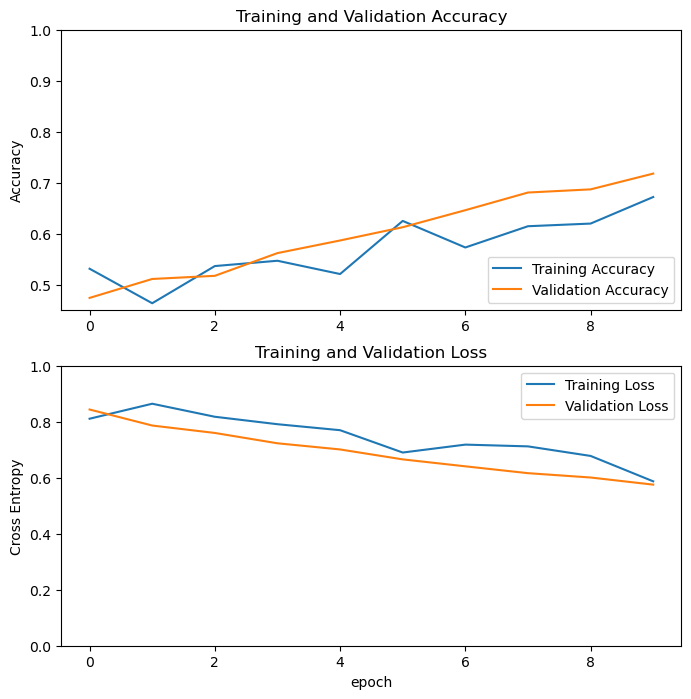

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [29]:
base_model.trainable = True


In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the base model:  154


In [31]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy'))

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [33]:
len(model.trainable_variables)

56

In [34]:
fine_tuning_epochs = 10
total_epochs = fine_tuning_epochs + initial_epochs

history_fine = model.fit(train_dataset, epochs=total_epochs, 
                         validation_data=validation_dataset, verbose=1,
                        initial_epoch=history.epoch[-1])

Epoch 10/20
63/63 [==============================] - 16s 123ms/step - loss: 0.2497 - accuracy: 0.8930 - val_loss: 0.0833 - val_accuracy: 0.9715
Epoch 11/20
63/63 [==============================] - 5s 78ms/step - loss: 0.1365 - accuracy: 0.9460 - val_loss: 0.0577 - val_accuracy: 0.9777
Epoch 12/20
63/63 [==============================] - 5s 77ms/step - loss: 0.1181 - accuracy: 0.9550 - val_loss: 0.0535 - val_accuracy: 0.9814
Epoch 13/20
63/63 [==============================] - 5s 76ms/step - loss: 0.1171 - accuracy: 0.9555 - val_loss: 0.0563 - val_accuracy: 0.9777
Epoch 14/20
63/63 [==============================] - 5s 77ms/step - loss: 0.1038 - accuracy: 0.9560 - val_loss: 0.0469 - val_accuracy: 0.9814
Epoch 15/20
63/63 [==============================] - 5s 79ms/step - loss: 0.0930 - accuracy: 0.9660 - val_loss: 0.0550 - val_accuracy: 0.9777
Epoch 16/20
63/63 [==============================] - 5s 77ms/step - loss: 0.0803 - accuracy: 0.9680 - val_loss: 0.0457 - val_accuracy: 0.9851
Epoc

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


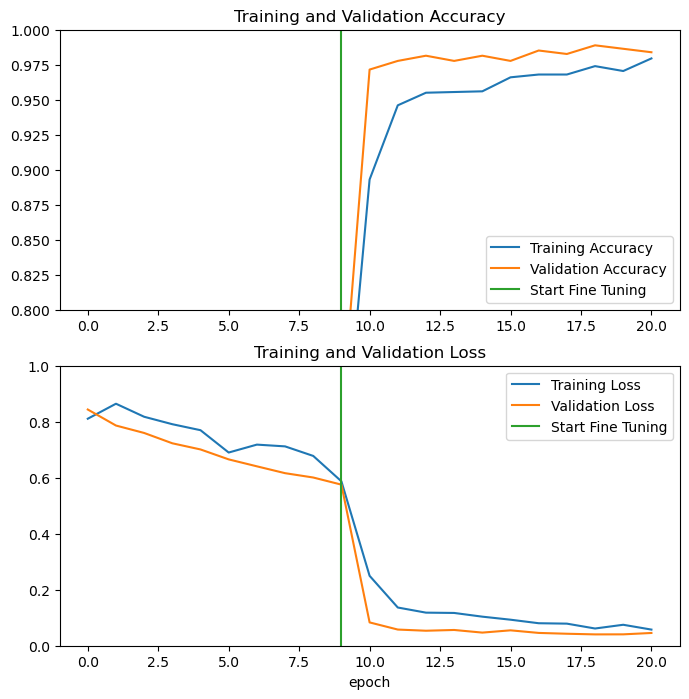

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


6/6 [==============================] - 0s 38ms/step - loss: 0.0262 - accuracy: 0.9896
Test accuracy : 0.9895833134651184
